In [ ]:
import gdown

gdown.download_folder('https://drive.google.com/drive/folders/1PpCVKJ-Lo2rXlERNG-1tRyXXCbZg-vnl?usp=sharing', output='/content/data')

In [ ]:
import pandas as pd
import numpy as np
import os

# join

In [348]:
def join_data(data_dir):

    building = pd.read_csv(os.path.join(data_dir,'building_20230808.csv'))
    building = building[building['is_actual'] == True]
    building.drop(columns=['is_updated', 'is_actual', 'type', 'municipality_id', 'post_prefix'], inplace=True)
    building.rename(columns={'id': 'target_building_id'}, inplace=True)

    prefix = pd.read_csv(os.path.join(data_dir,'prefix_20230808.csv'))
    prefix = prefix.drop(columns=['search_index','is_updated','is_actual'])
    prefix.rename(columns={'id':'prefix_id', 'name':'prefix_name', 'short_name':'prefix_short_name'}, inplace=True)

    district = pd.read_csv(os.path.join(data_dir,'district_20230808.csv'))
    district.drop(columns=['is_updated', 'is_actual'], inplace=True)
    district.rename(columns={'id':'district_id', 'name':'district_name'}, inplace=True)

    building = building.merge(district, on='district_id', how='left')

    town = pd.read_csv(os.path.join(data_dir,'town_20230808.csv'))
    town = town.drop(columns=['search_index','is_updated','is_actual','has_buildings'])
    town.rename(columns={'id':'town_id', 'name':'town_name', 'short_name': 'town_short_name'}, inplace=True)

    prefix = prefix.merge(town, on='town_id', how='left')

    geonim = pd.read_csv(os.path.join(data_dir,'geonim_20230808.csv'))
    geonim = geonim.drop(columns=['is_updated','is_actual'])
    geonim.rename(columns={'id':'geonim_id','type_id':'geonim_type_id', 'name':'geonim_name', 'short_name': 'geonim_short_name', 'only_name':'only_name_geonim'}, inplace=True)

    geonim_type = pd.read_csv(os.path.join(data_dir,'geonimtype_20230808.csv'))
    geonim_type = geonim_type.drop(columns=['is_updated','is_actual'])
    geonim_type.rename(columns={'id':'geonim_type_id', 'name':'geonim_type_name', 'short_name': 'geonim_type_short_name'}, inplace=True)

    geonim = geonim.merge(geonim_type, on='geonim_type_id', how='left')

    prefix = prefix.merge(geonim, on='geonim_id', how='left')

    area = pd.read_csv(os.path.join(data_dir,'area_20230808.csv'))
    area = area.drop(columns=['is_updated','is_actual'])
    area.rename(columns={'id':'area_id', 'type_id':'area_type_id', 'name':'area_name', 'short_name': 'area_short_name', 'only_name': 'only_name_area'}, inplace=True)

    area_type = pd.read_csv(os.path.join(data_dir,'areatype_20230808.csv'))
    area_type = area_type.drop(columns=['is_updated','is_actual'])
    area_type.rename(columns={'id':'area_type_id', 'name':'area_type_name', 'short_name': 'area_type_short_name'}, inplace=True)

    area = area.merge(area_type, on='area_type_id', how='left')

    prefix = prefix.merge(area, on='area_id', how='left')

    subrf = pd.read_csv(os.path.join(data_dir,'subrf_20230808.csv'))
    subrf = subrf.drop(columns=['is_updated','is_actual'])
    subrf.rename(columns={'id':'sub_rf_id', 'name':'subrf_name', 'short_name': 'subrf_short_name'}, inplace=True)

    prefix = prefix.merge(subrf, on='sub_rf_id', how='left')

    building = building.merge(prefix, on='prefix_id', how='left')
    building.drop(columns=['prefix_id', 'district_id', 'town_id', 'geonim_id', 'area_id', 'toponim_id', 'sub_rf_id',
                           'geonim_type_id', 'area_type_id'], inplace=True)
    building = building.drop_duplicates(subset=building.columns[1:])

    return building


# preprocess

In [349]:
import re
import math
def aug_town(building, town_pattern=re.compile(r'[а-я \.ё]+')):
    def get_town_name_type(town_adress):
        try:
            res = town_pattern.match(town_adress)

            town_type, town_name_only = town_adress[res.start():res.end()], town_adress[res.end():]
        except:
            town_type, town_name_only = math.nan, math.nan
        return town_type, town_name_only

    ent = building['town_name'].apply(get_town_name_type)
    building['only_name_town'] = ent.apply(lambda x: x[1])
    building['town_type_name'] = ent.apply(lambda x: x[0])

    ent = building['town_short_name'].apply(get_town_name_type)
    building['town_type_short'] = ent.apply(lambda x: x[0])
    return building

def aug_buildings_entities(building):
    cols = ['house', 'corpus', 'liter', 'build_number']
    cols_names = ['дом', 'корпус', 'Литер', 'строение']
    cols_names_short = ['д.', 'к.', 'л.', 'дача', 'стр']
    names = {k: v for k,v in zip(cols, cols_names)}
    short_names = {k: v for k,v in zip(cols, cols_names_short)}
    def aug_buildings_cols(x, name):
        if not isinstance(x, str) and math.isnan(x):
            return ''
        else:
            return f'{name} {x}'

    for col in cols:
        building[f'{col}_name'] = building[col].apply(lambda x: aug_house_cols(x,names[col]))
        building[f'{col}_short_name'] = building[col].apply(lambda x: aug_house_cols(x,short_names[col]))
    return building

def aug_df(building):
    building = aug_town(building)
    building = aug_buildings_entities(building)
    return building

data_dir = '/content/data/additional_data/'
building = join_data(data_dir)
building = aug_df(building)

<ipython-input-348-9f95fccb1906>:3: DtypeWarning: Columns (4,6,7,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  building = pd.read_csv(os.path.join(data_dir,'building_20230808.csv'))


# Аугментация df

In [342]:
from math import nan
import math
import random

def choice_prompt(df, prompt_cols_list, empty_prob):
    if random.choices([True, False], weights = [empty_prob, 1-empty_prob])[0]:
        return ''
    #prompt_cols_list.append('')
    prompt_col = random.choices(prompt_cols_list, weights=[1/len(prompt_cols_list)]*len(prompt_cols_list), k=1)[0]
    try:
        if prompt_col == '':
            return ''
        elif not isinstance(df[prompt_col], str) and math.isnan(df[prompt_col]):
            return ''
        else:
            return df[prompt_col]
    except:
        print(prompt_col, df[prompt_col])
        return ''




def aug_element(df_row, prompt_cols_list, empty_prob_list):
    prompt = ''
    for prompt_cols_list, prob in zip(prompt_cols_list, empty_prob_list):
        prompt = prompt + ' ' + str(choice_prompt(df_row, prompt_cols_list, prob))
    return prompt.strip()

def do_aug(df_aug_sample, prompt_cols_list, empty_prob_lists, times=1):
    #empty_prob_lists = [[0.3, 0, 0, 0, 0.1, 0.1, 0]]
    final_df = pd.DataFrame(columns=['prompt', 'target_building_id', 'target_address',
                                    'geonim_name', 'town_name', 'district_name', 'house', 'corpus', 'liter'])


    temp = df_aug_sample[['full_address','target_building_id']].copy().rename(columns={'full_address':'target_address'})
    length = temp.shape[0]
    times = times
    for i in range(0, times):
        temp = df_aug_sample[['full_address','target_building_id', 'geonim_name',
                            'town_name', 'district_name', 'house', 'corpus', 'liter']].copy().rename(columns={'full_address':'target_address'})
        for empty_prob_list_ind in range(len(empty_prob_lists)):
            temp['prompt'] = df_aug_sample.apply(lambda x: aug_element(x,prompt_cols_list, empty_prob_lists[empty_prob_list_ind]), axis=1)

            final_df = pd.concat([final_df, temp])
    return final_df


def get_prompt_cols_list():

    prompt_cols_list = [['town_name','town_short_name','only_name_town'],
                        ['area_name', 'area_short_name', 'only_name_area'],
                        ['geonim_name', 'geonim_short_name', 'only_name_geonim']]

    other_cols = []
    for col in ['house', 'corpus', 'liter', 'build_number']:
        other_cols.append([f'{col}_name', f'{col}_short_name', col])
    prompt_cols_list +=  other_cols
    return prompt_cols_list




In [344]:
def do_neg_aug(data_path, data_base_df, prompt_cols_list, empty_prob_lists=[[0.3, 0, 0, 0, 0.1, 0.1, 0]]):
    df = pd.read_csv(data_path, index_col=0).rename(columns={'target_building_id_fulladdress':'target_building_id'})
    df = df.merge(data_base_df.loc[:,['full_address', 'target_building_id']],
                  how='inner', on='target_building_id').rename(columns={'target_building_id':'full_address_id'})
    df_aug_sample = data_base_df[data_base_df['target_building_id'].isin(df['target_building_id_prompt'].values)]

    final_df = do_aug(df_aug_sample, prompt_cols_list, empty_prob_lists)

    df = df.rename(columns={'target_building_id_prompt': 'target_building_id'})
    df = df.merge(final_df.loc[:, ['prompt','target_building_id']], how='inner', on='target_building_id')

    temp_df = pd.DataFrame(columns=['full_address_id', 'target_building_id', 'scores', 'full_address'])
    temp_df['full_address_id'] = df['full_address_id'].values
    temp_df['target_building_id'] = df['full_address_id'].values
    temp_df['full_address'] = df['full_address'].values
    temp_df['scores'] = 1

    df_aug_sample = temp_df.drop(columns=['full_address']).merge(building, how='inner', on='target_building_id')
    df_aug_sample
    temp_df = temp_df.drop_duplicates().merge(do_aug(df_aug_sample, prompt_cols_list, empty_prob_lists).loc[:, ['prompt', 'target_building_id']], how='inner', on='target_building_id')

    df = pd.concat([df,temp_df])

    return df.drop_duplicates()


In [351]:
# dataset to train model
do_neg_aug('/content/negatives_261k.csv', data_base_df=building, prompt_cols_list=get_prompt_cols_list()).to_csv('neg_261.csv')

# Новый раздел

In [ ]:
building = building.drop_duplicates(subset=['full_address'])
df_aug_sample = building.sample(n=5000, random_state=20)
df_aug_sample

## base aug

In [ ]:
def get_aug_by_default_cols_comb(df, target_adress_col, use_aug_cols, prob):
    #df = df.fillna('')
    df_sample = df.sample(frac=prob, random_state=42)

    #df_sample = df_sample.loc[:,[target_adress_col,'target_building_id']+use_aug_cols]

    final_df = pd.DataFrame(columns=['prompt', 'target_building_id', 'target_address', 'geonim_name','town_name', 'district_name', 'house', 'corpus', 'liter'])
    final_df['target_address'] = df_sample[target_adress_col]
    final_df['target_building_id'] = df_sample['target_building_id']
    final_df.loc[:, ['geonim_name','town_name', 'district_name', 'house', 'corpus', 'liter']] = df_sample.loc[:, ['geonim_name','town_name', 'district_name', 'house', 'corpus', 'liter']]
    prompt = df_sample[use_aug_cols[0]].astype(str).values

    for col in use_aug_cols[1:]:
        prompt = prompt + ' ' + df_sample[col].astype(str).values
    final_df['prompt'] = prompt
    return final_df



In [ ]:
aug1 = get_aug_by_default_cols_comb(df_aug_sample, 'full_address', ['short_address'], 1)
#aug2 = get_aug_by_default_cols_comb(building, 'full_address', ['geonim_short_name', 'house', 'corpus', 'liter', 'villa', 'parcel'], 0.5, final_df=final_df)
base_aug = aug1
base_aug

,prompt,target_building_id,target_address,geonim_name,town_name,district_name,house,corpus,liter
94421,"г.Санкт-Петербург, Каменноостровский пр., д. 4...",107906,"г.Санкт-Петербург, Каменноостровский проспект,...",Каменноостровский проспект,г.Санкт-Петербург,Петроградский,43,NaN,А
11536,"г.Пушкин, Малая ул., д. 52а, л. Б",12486,"город Пушкин, Малая улица, дом 52а, литера Б",Малая улица,город Пушкин,Пушкинский,52а,NaN,Б
69342,"пос. Александровская, Пушкинская ул., д. 36, л. А",79048,"посёлок Александровская, Пушкинская улица, дом...",Пушкинская улица,посёлок Александровская,Пушкинский,36,NaN,А
64734,"г.Санкт-Петербург, ул. Ушинского, д. 4, к. 3, ...",73765,"г.Санкт-Петербург, улица Ушинского, дом 4, кор...",улица Ушинского,г.Санкт-Петербург,Калининский,4,3,А
59496,"г.Санкт-Петербург, наб. Обводного канала, д. 1...",67729,"г.Санкт-Петербург, набережная Обводного канала...",набережная Обводного канала,г.Санкт-Петербург,Адмиралтейский,138,6,А
...,...,...,...,...,...,...,...,...,...
28158,"пос. Песочный, Карьерный проезд, д. 7, л. А",31567,"посёлок Песочный, Карьерный проезд, дом 7, лит...",Карьерный проезд,посёлок Песочный,Курортный,7,NaN,А
5568,"г.Санкт-Петербург, пр. Большевиков, д. 75, к. ...",5645,"г.Санкт-Петербург, проспект Большевиков, дом 7...",проспект Большевиков,г.Санкт-Петербург,Невский,75,2,А
71696,"г.Санкт-Петербург, наб. реки Фонтанки, д. 20, ...",81747,"г.Санкт-Петербург, набережная реки Фонтанки, д...",набережная реки Фонтанки,г.Санкт-Петербург,Центральный,20,NaN,В
32197,"муниципальный округ Константиновское, территор...",36186,"муниципальный округ Константиновское, территор...",Ушаковская улица,муниципальный округ Константиновское,Красносельский,13а,NaN,А


## all data base aug

In [ ]:
building = building.drop_duplicates(subset=['full_address'])
df_aug_sample = building


empty_prob_lists = [[0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 1],
                    [0, 0, 0, 0, 0, 1, 1],
                    [0, 0, 0, 0, 1, 1, 1],
                    [0, 0, 0, 1, 1, 1, 1],

                    [1, 0, 0, 0, 0, 0, 1],
                    [1, 0, 0, 0, 0, 1, 1],
                    [1, 0, 0, 0, 1, 1, 1],
                    [1, 0, 0, 0, 1, 1, 1],

                    [1, 1, 0, 0, 0, 0, 1],
                    [1, 1, 0, 0, 0, 1, 1],
                    [1, 1, 0, 0, 1, 1, 1],
                    [1, 1, 0, 0, 1, 1, 1]
                    ]
empty_prob_lists = [[0, 0, 0, 0, 0, 0, 0],
                    [1, 1, 0, 0, 0, 0, 1],
                    [1, 0, 0, 0, 0, 0, 1]]

In [ ]:
final_df = do_aug(df_aug_sample, empty_prob_lists)

In [ ]:
temp_df = pd.concat([df_aug_sample[['target_building_id', 'full_address']], final_df[['prompt','target_building_id']]
           .rename(columns={'prompt':'full_address'})], ignore_index=True)

In [ ]:
temp_df = df_aug_sample.drop(columns=['full_address']).merge(temp_df, how='inner', on='target_building_id')

In [ ]:
temp_df = temp_df.drop_duplicates(subset=['full_address'])

In [ ]:
temp_df.columns

Index(['target_building_id', 'house', 'corpus', 'liter', 'villa', 'parcel',
       'is_actual', 'short_address', 'build_number', 'district_name',
       'prefix_name', 'prefix_short_name', 'has_buildings', 'town_name',
       'town_short_name', 'geonim_name', 'geonim_short_name',
       'only_name_geonim', 'geonim_type_name', 'geonim_type_short_name',
       'area_name', 'area_short_name', 'only_name_area', 'area_type_name',
       'area_type_short_name', 'subrf_name', 'subrf_short_name',
       'only_name_town', 'town_type_name', 'town_type_short',
       'town_empty_type', 'house_name', 'house_short_name', 'corpus_name',
       'corpus_short_name', 'liter_name', 'liter_short_name',
       'build_number_name', 'build_number_short_name', 'full_address'],
      dtype='object')

In [ ]:
temp_df[['target_building_id', 'is_actual', 'full_address']].to_csv('/content/drive/MyDrive/Digital hack/train_dataset_Датасет/aug_all_base.csv')

# Новый раздел

In [ ]:
final_df['prompt'].duplicated().sum()

71

In [ ]:
#final_df = final_df.drop_duplicates(subset=['target_address'])

278

In [ ]:
final_df.duplicated(subset=['target_address']).sum()

65000

In [ ]:
final_df = final_df.drop_duplicates(subset=['prompt'])
final_df

,prompt,target_building_id,target_address,geonim_name,town_name,district_name,house,corpus,liter
126529,г.Санкт-Петербург пр. Энергетиков дом 4 3.0 ...,216527,"г.Санкт-Петербург, проспект Энергетиков, дом 4...",проспект Энергетиков,г.Санкт-Петербург,Красногвардейский,4,3.0,NaN
20191,г.Санкт-Петербург улица Ушинского 22/97 А,22365,"г.Санкт-Петербург, улица Ушинского, дом 22/97,...",улица Ушинского,г.Санкт-Петербург,Калининский,22/97,NaN,А
119398,Пушкин территория Волхонское улица Грёз 2 л. А,205989,"город Пушкин, территория Волхонское, улица Грё...",улица Грёз,город Пушкин,Пушкинский,2,NaN,А
73522,г.Санкт-Петербург Октябрьская наб. дом 6 л. К,83836,"г.Санкт-Петербург, Октябрьская набережная, дом...",Октябрьская набережная,г.Санкт-Петербург,Невский,6,NaN,К
78345,г.Санкт-Петербург Тихорецкий проспект дом 21 ...,89380,"г.Санкт-Петербург, Тихорецкий проспект, дом 21...",Тихорецкий проспект,г.Санкт-Петербург,Калининский,21,NaN,К
...,...,...,...,...,...,...,...,...,...
28158,"пос. Песочный, Карьерный проезд, д. 7, л. А",31567,"посёлок Песочный, Карьерный проезд, дом 7, лит...",Карьерный проезд,посёлок Песочный,Курортный,7,NaN,А
5568,"г.Санкт-Петербург, пр. Большевиков, д. 75, к. ...",5645,"г.Санкт-Петербург, проспект Большевиков, дом 7...",проспект Большевиков,г.Санкт-Петербург,Невский,75,2,А
71696,"г.Санкт-Петербург, наб. реки Фонтанки, д. 20, ...",81747,"г.Санкт-Петербург, набережная реки Фонтанки, д...",набережная реки Фонтанки,г.Санкт-Петербург,Центральный,20,NaN,В
32197,"муниципальный округ Константиновское, территор...",36186,"муниципальный округ Константиновское, территор...",Ушаковская улица,муниципальный округ Константиновское,Красносельский,13а,NaN,А


<Axes: >

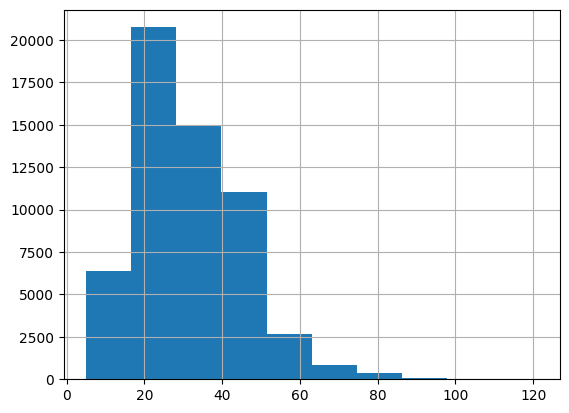

In [ ]:
final_df['prompt'].apply(lambda x: len(x)).hist()

In [ ]:
final_df = final_df[final_df['prompt'].apply(lambda x: len(x)) > 4]

In [ ]:
final_df

,prompt,target_building_id,target_address,geonim_name,town_name,district_name,house,corpus,liter
126529,г.Санкт-Петербург пр. Энергетиков дом 4 3.0 ...,216527,"г.Санкт-Петербург, проспект Энергетиков, дом 4...",проспект Энергетиков,г.Санкт-Петербург,Красногвардейский,4,3.0,NaN
20191,г.Санкт-Петербург улица Ушинского 22/97 А,22365,"г.Санкт-Петербург, улица Ушинского, дом 22/97,...",улица Ушинского,г.Санкт-Петербург,Калининский,22/97,NaN,А
119398,Пушкин территория Волхонское улица Грёз 2 л. А,205989,"город Пушкин, территория Волхонское, улица Грё...",улица Грёз,город Пушкин,Пушкинский,2,NaN,А
73522,г.Санкт-Петербург Октябрьская наб. дом 6 л. К,83836,"г.Санкт-Петербург, Октябрьская набережная, дом...",Октябрьская набережная,г.Санкт-Петербург,Невский,6,NaN,К
78345,г.Санкт-Петербург Тихорецкий проспект дом 21 ...,89380,"г.Санкт-Петербург, Тихорецкий проспект, дом 21...",Тихорецкий проспект,г.Санкт-Петербург,Калининский,21,NaN,К
...,...,...,...,...,...,...,...,...,...
28158,"пос. Песочный, Карьерный проезд, д. 7, л. А",31567,"посёлок Песочный, Карьерный проезд, дом 7, лит...",Карьерный проезд,посёлок Песочный,Курортный,7,NaN,А
5568,"г.Санкт-Петербург, пр. Большевиков, д. 75, к. ...",5645,"г.Санкт-Петербург, проспект Большевиков, дом 7...",проспект Большевиков,г.Санкт-Петербург,Невский,75,2,А
71696,"г.Санкт-Петербург, наб. реки Фонтанки, д. 20, ...",81747,"г.Санкт-Петербург, набережная реки Фонтанки, д...",набережная реки Фонтанки,г.Санкт-Петербург,Центральный,20,NaN,В
32197,"муниципальный округ Константиновское, территор...",36186,"муниципальный округ Константиновское, территор...",Ушаковская улица,муниципальный округ Константиновское,Красносельский,13а,NaN,А


In [ ]:
final_df.to_csv('train_aug_data.csv')